In [8]:
import altair as alt
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [327]:
HOUSEHOLD_ID = 'hhid'

HOUSEHOLD_SIZE = 'hhsize'
VEHICLE_COUNT = 'vehicle_count'
CHILDREN_COUNT = 'numchildren'
INCOME = 'hhincome_broad'
HOME_OWNERSHIP = 'home_ownership'
OFFSTREET_PARKING = 'offpark'
YEAR_RESIDENCE = 'year_residence'
WEIGHT = 'hh_wt_revised'

MEAN_AGE = 'mean_age'
PROP_WHITE = 'proportion_white'
PROP_BLACK = 'proportion_black'
PROP_ASIAN = 'proportion_asian'
PROP_HISPANIC = 'proportion_hispanic'
YEAR_EDUCATION = 'mean_education_year'
PROP_EMPLOYED = 'proportion_employed'
PROP_STUDENT = 'proportion_student'
PERSON_COUNT = 'personid_count'

MEAN_DISTANCE = 'mean_distance'
MEAN_DEPART_TIME = 'mean_depart_time'
MEAN_NUMBER_TRAVELERS = 'mean_num_travelers'
PROP_DRIVING_ALONE = 'prop_driving_alone'
PROP_DRIVING_WITH_OTHERS = 'prop_driving_with_others'
PROP_TRANSIT = 'prop_transit'
PROP_BIKING = 'prop_biking'
PROP_WALKING = 'prop_walking'
MEAN_DURATION = 'mean_duration'
PROP_WENT_HOME = 'prop_went_home'
PROP_WENT_WORK = 'prop_went_work'
PROP_ERRANDS = 'prop_errands'
PROP_SOCIAL = 'prop_social'
PROP_GAVE_RIDE = 'prop_gave_ride'
TRIP_COUNT = 'number_of_trips'
PROP_FEMALE = 'proportion_female'

# new variable to be added to clustered data:
NO_VEHICLE = 'no_vehicle'
MEAN_DRIVING_DURATION = 'mean_driving_duration'
MEAN_TRANSIT_DURATION = 'mean_transit_duration'
MEAN_BIKING_DURATION = 'mean_biking_duration'
MEAN_WALKING_DURATION = 'mean_walking_duration'

PROP_DRIVING_BROAD = 'prop_driving_broad'
NUM_CLUSTER = 6
CLUSTER = 'cluster'

DROP_FEATURES = [PROP_WHITE, PROP_BLACK, PROP_ASIAN, PROP_HISPANIC, PROP_FEMALE, NO_VEHICLE, 
                MEAN_DRIVING_DURATION, MEAN_TRANSIT_DURATION, MEAN_BIKING_DURATION, 
                MEAN_WALKING_DURATION, PROP_DRIVING_BROAD]

# for return parameters
DRIVING_THRESHOLD = 'driving_threshold'
TRANSIT_THRESHOLD = 'transit_threshold'
BIKING_THRESHOLD = 'biking_threshold'
WALKING_THRESHOLD = 'walking_threshold'

DRIVING_WEIGHT = 'driving_weight'
TRANSIT_WEIGHT = 'transit_weight'
BIKING_WEIGHT = 'biking_weight'
WALKING_WEIGHT = 'walking_weight'

MEDIAN_INCOME = 'median_income'
MEAN_CHILDREN_COUNT = 'mean_number_children'


SELECT_FEATURES = [MEAN_DRIVING_DURATION, 
                   MEAN_TRANSIT_DURATION, 
                   MEAN_BIKING_DURATION, 
                   MEAN_WALKING_DURATION, 
                   PROP_DRIVING_BROAD,
                   PROP_TRANSIT,
                   PROP_BIKING,
                   PROP_WALKING, 
                   CHILDREN_COUNT,
                   INCOME, 
                   WEIGHT, 
                   CLUSTER,
                   MEAN_AGE]

QUANTILE_FEATURES_85 = [MEAN_DRIVING_DURATION, MEAN_TRANSIT_DURATION, 
                    MEAN_BIKING_DURATION, MEAN_WALKING_DURATION]
MEAN_FEATURES = [PROP_DRIVING_BROAD, PROP_TRANSIT, PROP_BIKING, PROP_WALKING, 
                CHILDREN_COUNT, MEAN_AGE]
QUANTILE_FEATURES_50 = [INCOME]


RETURN_FEATURES = [DRIVING_THRESHOLD, TRANSIT_THRESHOLD, BIKING_THRESHOLD, WALKING_THRESHOLD, 
                   DRIVING_WEIGHT, TRANSIT_WEIGHT, BIKING_WEIGHT, WALKING_WEIGHT, 
                   MEAN_CHILDREN_COUNT, MEDIAN_INCOME]


UNDER_25000 = "under_25000"
BETWEEN_25000_49999 = "25000_49999"
BETWEEN_50000_74999 = "50000_74999"
BETWEEN_75000_99999 = "75000_99999"
MORE_THAN_100000 = "100000_or_more"
CUMSUM_WEIGHT = "cumsum_weight"
WEIGHTED_VALUES = "weighted_values"

In [10]:
def clustering_data(dat, drop_list, n_cluster):
    
    # prepare for K-means clustering
    dropna_columns = set(dat.columns) - set(DROP_FEATURES)
    dat = dat.dropna(subset = dropna_columns)
    
    index_nomissing = dat[HOUSEHOLD_ID]
    dat = dat.set_index(HOUSEHOLD_ID)
    # we're not using some features here
    newdat = dat.drop(columns = drop_list)
    
    normalized_dat = (newdat - newdat.mean()) / newdat.std()
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(normalized_dat)
    clustered = pd.DataFrame({CLUSTER: kmeans.labels_}, index = index_nomissing)
    final_dat = dat.join(clustered)   
    
    for i in range(0, n_cluster):
        print("Cluster ", i, " has ", len(final_dat[final_dat[CLUSTER] == i]), " elements")
        if (len(final_dat[final_dat[CLUSTER] == i]) < 10):
            print("\nWe are dropping cluster ", i, " because the cluster only has ", 
                 len(final_dat[final_dat[CLUSTER] == i]), " observations \n")
            final_dat = final_dat[final_dat[CLUSTER] != i]    
    print(final_dat[CLUSTER].unique())
    
    return(final_dat)

In [11]:
def cluster_summary(clustered_dat):
    cluster_means = clustered_dat.groupby([CLUSTER], as_index = True).agg(
        {MEAN_AGE: 'mean', 
         PROP_EMPLOYED: 'mean', 
         PROP_STUDENT: 'mean', 
         YEAR_EDUCATION: 'mean', 
         YEAR_RESIDENCE: 'mean', 
         INCOME: 'median', # income is median
         CHILDREN_COUNT: 'mean', 
         PROP_DRIVING_ALONE: 'mean', 
         PROP_DRIVING_WITH_OTHERS: 'mean', 
         PROP_BIKING: 'mean', 
         PROP_WALKING: 'mean', 
         PROP_TRANSIT: 'mean', 
         VEHICLE_COUNT: 'mean', 
         PROP_WENT_HOME: 'mean', 
         PROP_WENT_WORK: 'mean', 
         PROP_ERRANDS: 'mean', 
         PROP_SOCIAL: 'mean', 
         PROP_GAVE_RIDE: 'mean',
         PROP_WHITE:'mean', 
         PROP_BLACK: 'mean', 
         PROP_ASIAN: 'mean', 
         PROP_HISPANIC: 'mean',
         HOUSEHOLD_SIZE: 'mean', 
         TRIP_COUNT: 'mean', 
         MEAN_DISTANCE: 'mean', 
         MEAN_DURATION: 'mean', 
         PROP_FEMALE: 'mean',
         NO_VEHICLE: 'mean', 
         MEAN_DRIVING_DURATION: 'mean', 
         MEAN_TRANSIT_DURATION: 'mean', 
         MEAN_BIKING_DURATION: 'mean', 
         MEAN_WALKING_DURATION: 'mean'})
    
    return(cluster_means)

In [12]:
def calculate_85_quantile(series):
       return(series.quantile(.85))

def return_features(clustered_dat):
    cluster_mean = clustered_dat.groupby([CLUSTER], as_index = True).agg(
        {MEAN_DRIVING_DURATION: calculate_85_quantile, 
         MEAN_TRANSIT_DURATION: calculate_85_quantile, 
         MEAN_BIKING_DURATION: calculate_85_quantile, 
         MEAN_WALKING_DURATION: calculate_85_quantile, 
         PROP_DRIVING_BROAD: 'mean',
         PROP_TRANSIT: 'mean',
         PROP_BIKING: 'mean',
         PROP_WALKING: 'mean',
         CHILDREN_COUNT: 'mean',
         INCOME: 'median', })

    quantiles = pd.Series(clustered_dat[[MEAN_DRIVING_DURATION, MEAN_TRANSIT_DURATION, 
                             MEAN_BIKING_DURATION, MEAN_WALKING_DURATION]].agg(calculate_85_quantile))
    means = pd.Series(clustered_dat[[PROP_DRIVING_BROAD, PROP_TRANSIT, PROP_BIKING, 
                            PROP_WALKING, CHILDREN_COUNT]].agg('mean'))
    medians = pd.Series(clustered_dat[[INCOME]].agg('median'))
    neutral = pd.concat([quantiles, means, medians])
    
    cluster_mean = cluster_mean.append(neutral, ignore_index=True)
    cluster_mean.rename(columns = {MEAN_DRIVING_DURATION: DRIVING_THRESHOLD,
                                      MEAN_TRANSIT_DURATION: TRANSIT_THRESHOLD,
                                      MEAN_BIKING_DURATION: BIKING_THRESHOLD,
                                      MEAN_WALKING_DURATION: WALKING_THRESHOLD,
                                      PROP_DRIVING_BROAD: DRIVING_WEIGHT,
                                      PROP_TRANSIT: TRANSIT_WEIGHT,
                                      PROP_BIKING: BIKING_WEIGHT,
                                      PROP_WALKING: WALKING_WEIGHT,
                                      CHILDREN_COUNT: MEAN_CHILDREN_COUNT,
                                      INCOME: MEDIAN_INCOME}, inplace=True)

                                      
    return(cluster_mean)                                  

In [335]:
# load pre-processed data
#result = pd.read_csv('personas_processed_psrcdat.csv', index_col=0)

#clustered = clustering_data(result, DROP_FEATURES, NUM_CLUSTER)
#clustered.to_csv('preprocessed_psrc_with_cluster.csv')


clustered = pd.read_csv('preprocessed_psrc_with_cluster.csv', index_col = 0)
clustered.head()

,numchildren,hh_wt_revised,hhincome_broad,hhsize,vehicle_count,no_vehicle,home_ownership,offpark,year_residence,mean_age,proportion_white,mean_education_year,proportion_black,proportion_asian,proportion_hispanic,proportion_employed,proportion_student,proportion_female,mean_distance,mean_depart_time,mean_num_travelers,prop_driving_alone,prop_driving_with_others,prop_transit,prop_biking,prop_walking,mean_duration,mean_driving_duration,mean_transit_duration,mean_biking_duration,mean_walking_duration,prop_went_home,prop_went_work,prop_errands,prop_social,prop_gave_ride,number_of_trips,prop_driving_broad,cluster
hhid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17100024,1,26.224981,4.0,3,1,0,1.0,1,2,20.333333,1.0,6.0,0.0,0.0,0.0,1.0,0.5,1.0,1.151667,621.071429,1.285714,0.357143,0.0,0.071429,0.214286,0.357143,5.071429,7.0,7.000000,5.0,2.800000,0.50000,0.285714,0.142857,0.000000,0.071429,14,0.357143,0
17100052,0,25.692826,1.0,1,0,1,0.0,1,20,69.500000,1.0,6.0,0.0,0.0,0.0,1.0,0.0,1.0,0.847550,735.000000,1.000000,0.000000,0.0,0.600000,0.000000,0.400000,5.400000,NaN,6.666667,NaN,3.500000,0.20000,0.000000,0.600000,0.200000,0.000000,5,0.000000,3
17100059,0,47.768728,5.0,1,0,1,0.0,0,1,29.500000,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,3.713700,947.631579,2.236842,0.045455,0.0,0.181818,0.000000,0.772727,18.921053,20.0,36.250000,NaN,7.176471,0.30303,0.272727,0.090909,0.333333,0.000000,38,0.045455,2
17100102,0,318.861344,4.0,1,1,0,0.0,1,5,39.500000,1.0,6.0,0.0,1.0,0.0,1.0,0.0,0.0,42.893986,589.000000,1.400000,1.000000,0.0,0.000000,0.000000,0.000000,46.000000,46.0,NaN,NaN,NaN,0.20000,0.200000,0.200000,0.000000,0.400000,5,1.000000,5
17100108,0,24.899462,5.0,2,1,0,0.0,10,2,29.500000,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.5,7.605270,626.250000,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,14.750000,NaN,NaN,NaN,6.500000,0.50000,0.500000,0.000000,0.000000,0.000000,4,0.000000,1


In [345]:
aa = cluster_summary(clustered)
bb = return_features(clustered)
pd.options.display.max_columns = None

nicknames = pd.Series(['family-(wo)man', 'fit-urbanites', 'tired-commuter', 'jolly-retiree', 'olde-Seattleite'])
nicknames2 = pd.Series(['family-(wo)man', 'fit-urbanites', 'tired-commuter', 'jolly-retiree', 'olde-Seattleite', 'neutral'])
aa = aa.set_index(nicknames)
bb = bb.set_index(nicknames2)
aa.loc[:, ('mean_age', 'year_residence', 'hhincome_broad',
       'numchildren', 'prop_driving_alone', 'prop_driving_with_others',
       'prop_biking', 'prop_walking', 'prop_transit', 'vehicle_count',
       'prop_went_home', 'prop_went_work', 'prop_errands', 'prop_social',
       'prop_gave_ride', 'proportion_white', 'proportion_black',
       'proportion_asian', 'proportion_hispanic', 'hhsize', 'number_of_trips',
       'mean_distance', 'mean_duration', 'proportion_female', 'no_vehicle',
       'mean_driving_duration', 'mean_transit_duration',
       'mean_biking_duration', 'mean_walking_duration')]
bb

# save the data
#aa.to_csv('clustered_psrcdat.csv')
#bb.to_csv('clustered_psrcreturn.csv')

,driving_threshold,transit_threshold,biking_threshold,walking_threshold,driving_weight,transit_weight,biking_weight,walking_weight,mean_number_children,median_income
family-(wo)man,19.366667,33.621053,24.156863,14.363333,0.670412,0.077169,0.035622,0.216797,1.518919,5.0
fit-urbanites,23.000000,22.000000,18.575000,7.500000,0.083042,0.420826,0.062879,0.433252,0.030501,3.0
tired-commuter,27.204151,43.841667,51.503125,21.570833,0.483971,0.137947,0.033468,0.344614,0.020089,3.0
jolly-retiree,18.586207,26.791667,17.400000,6.725000,0.451814,0.188155,0.008386,0.351645,0.006270,2.0
olde-Seattleite,22.755000,27.675000,20.382692,9.733333,0.833571,0.055390,0.016972,0.094067,0.017544,5.0
neutral,23.000000,34.500000,27.646429,14.580357,0.472754,0.194121,0.033090,0.300036,0.172928,4.0


In [337]:
def multiply_weights(column, weights):
    return column * weights

def divide_weights(column, weights):
    return column / weights

def cluster_summary_with_weights(clustered_dat):
    
    input_dat = clustered_dat[[MEAN_AGE, INCOME, HOUSEHOLD_SIZE, YEAR_EDUCATION, NO_VEHICLE, 
                        PROP_DRIVING_BROAD, PROP_DRIVING_ALONE, PROP_DRIVING_WITH_OTHERS,
                        PROP_TRANSIT, PROP_BIKING, PROP_WALKING, PROP_WENT_HOME,
                        PROP_WENT_WORK, PROP_ERRANDS, PROP_SOCIAL, PROP_GAVE_RIDE, 
                        MEAN_DISTANCE, MEAN_DURATION, PROP_WHITE, PROP_BLACK, PROP_ASIAN, 
                        PROP_HISPANIC, PROP_FEMALE]].copy()
    
    input_dat[INCOME] = input_dat[INCOME].replace([1, 2, 3, 4, 5], [UNDER_25000, BETWEEN_25000_49999, 
                                        BETWEEN_50000_74999, BETWEEN_75000_99999, MORE_THAN_100000])
    
    # create dummy variables for income
    dummy_income = pd.get_dummies(input_dat[INCOME])
    dummy_income.loc[input_dat[INCOME].isnull(), :] = np.nan
    input_dat = pd.concat([input_dat, dummy_income], axis = 1)
    input_dat = input_dat.drop(columns = [INCOME])
    
    # multiply weights to each column of dat
    weighted_dat = input_dat.apply(lambda x: multiply_weights(x, clustered_dat[WEIGHT]))
    #print(weighted_dat.head())
    weighted_dat = pd.concat([weighted_dat, clustered_dat[WEIGHT], clustered_dat[CLUSTER]], axis = 1)
    
    cluster_sums = weighted_dat.groupby([CLUSTER], as_index = True).agg('sum')
    
    weighted_cluster_means = cluster_sums.apply(lambda x: divide_weights(x, cluster_sums[WEIGHT]))
    # drop WEIGHT as all value will be 1.0
    weighted_cluster_means = weighted_cluster_means.drop(columns = WEIGHT)
    
    
    # add a neutral element
    weighted_neutral = pd.Series(weighted_dat.sum())
    weighted_neutral = weighted_neutral / weighted_neutral[WEIGHT]
    # drop cluster/weight (used in calculation but unnecessary for further analysis) 
    weighted_neutral = weighted_neutral.drop([CLUSTER, WEIGHT])

    weighted_cluster_means = weighted_cluster_means.append(weighted_neutral, ignore_index=True)
        
    cluster_names = pd.Series(["family_woman", "fit_urbanite", "tired_commuter", 
                               "jolly_retiree", "olde_Seattlite", "neutral"])
    
    weighted_cluster_means = weighted_cluster_means.set_index(cluster_names)

    return(weighted_cluster_means)


In [338]:
weighted_cluster_summary = cluster_summary_with_weights(clustered)
weighted_cluster_summary

,mean_age,hhsize,mean_education_year,no_vehicle,prop_driving_broad,prop_driving_alone,prop_driving_with_others,prop_transit,prop_biking,prop_walking,prop_went_home,prop_went_work,prop_errands,prop_social,prop_gave_ride,mean_distance,mean_duration,proportion_white,proportion_black,proportion_asian,proportion_hispanic,proportion_female,100000_or_more,25000_49999,50000_74999,75000_99999,under_25000
family_woman,27.568762,3.744391,3.690088,0.014139,0.695241,0.669929,0.025312,0.084130,0.056627,0.164002,0.364571,0.240085,0.174464,0.097374,0.123506,7.138784,13.301002,0.653858,0.007697,0.166851,0.045630,0.460038,0.590943,0.015063,0.308864,0.081740,0.003390
fit_urbanite,32.496404,1.661167,4.085982,0.355963,0.101521,0.091149,0.010372,0.328528,0.112826,0.457124,0.397513,0.375894,0.153668,0.066392,0.006532,4.231496,11.627912,0.741531,0.021556,0.215047,0.022058,0.547546,0.302986,0.278115,0.220438,0.073925,0.124537
tired_commuter,32.602315,1.434728,4.313882,0.252714,0.490880,0.404360,0.086520,0.144176,0.061105,0.303839,0.309423,0.193072,0.217815,0.252619,0.027028,7.503569,20.578634,0.844979,0.036077,0.072215,0.051044,0.477097,0.259758,0.242083,0.074443,0.230268,0.193448
jolly_retiree,65.106105,1.416000,3.882719,0.340949,0.459968,0.424090,0.035878,0.173540,0.001392,0.365099,0.388774,0.018420,0.455189,0.111116,0.026501,3.141343,10.925520,0.904295,0.005238,0.070677,0.011770,0.604693,0.222292,0.217686,0.093917,0.155467,0.310638
olde_Seattlite,45.369904,1.774997,4.045185,0.000000,0.877845,0.868985,0.008860,0.043356,0.015791,0.063009,0.336992,0.359980,0.193951,0.095680,0.013396,35.757656,22.593090,0.889655,0.013890,0.065946,0.041349,0.334656,0.562468,0.092900,0.109139,0.083647,0.151845
neutral,41.728917,1.988262,3.999988,0.171710,0.567570,0.537066,0.030504,0.140969,0.044179,0.247282,0.357726,0.245121,0.239349,0.120516,0.037281,14.078234,16.421639,0.817244,0.016047,0.111221,0.034699,0.470361,0.406378,0.159221,0.155378,0.120500,0.158524


In [167]:
#################################
# save weighted cluster summary##############
#weighted_cluster_summary.to_csv("weighted_cluster_summary.csv")

In [339]:
def calculate_weighted_quantile(input_dat, values_column, weights_column=WEIGHT, quantile_val = 0.5):
    """
    This function takes a Data Frame with two columns, 
    one is value and the other is survey weight, 
    and computes the weighted quantile of the value. 
    The output will be one single value (right?) which is the value of 
    the quantile
    Input:
        input_dat: data frame with return values & weights
        values_column: name of the column with return values
        weights_column: name of the weights column
        quantile_val: quantile you want to know
    Output:
        single value of the desired quantile
    """
    input_dat = input_dat[[values_column, weights_column]].copy()
    input_dat = input_dat.dropna()
    input_dat = input_dat.sort_values(by = values_column)
    # normalized cumulative sum
    input_dat[CUMSUM_WEIGHT] = np.cumsum(input_dat[weights_column]) / input_dat[weights_column].sum()
    
    idx1 = input_dat[input_dat[CUMSUM_WEIGHT] <= quantile_val].index
    idx2 = input_dat[input_dat[CUMSUM_WEIGHT] >= quantile_val].index
    
    if ( len(idx1) != 0):
        if (idx1[len(idx1) - 1] == idx2[0]):
            #print("they are same")
            return(dummy.loc[idx2[0], MEAN_AGE])
        else: 
            #print("they are not the same")
            return( (input_dat.loc[idx1[len(idx1) - 1], values_column] + input_dat.loc[idx2[0], values_column]) / 2 ) 
    else: 
        return(0)
    
calculate_weighted_quantile(clustered.iloc[:15, :], MEAN_AGE, WEIGHT, 0.50)
#you can test it with unit tests using 0.5, etc..

30.166666666666664

In [340]:
dummy = clustered[[MEAN_AGE, WEIGHT]].iloc[:15, :].copy()
#print(dummy)
dummy = dummy.sort_values(by = MEAN_AGE)
dummy["cumsum_weight"] = np.cumsum(dummy[WEIGHT]) / dummy[WEIGHT].sum()
#print(dummy)
idx1 = dummy[dummy["cumsum_weight"] <= .5].index
idx2 = dummy[dummy["cumsum_weight"] >= .5].index
print( idx1[len(idx1) - 1])
print(idx2[0])
#print(dummy.loc[idx1, MEAN_AGE])
#print(dummy.loc[idx2, MEAN_AGE])

if (idx1[len(idx1) - 1] == idx2[0]):
    print("they are same")
    print(dummy.loc[idx2[0], MEAN_AGE])

else: 
    print("they are not the same")
    print( (dummy.loc[idx1[len(idx1) - 1], MEAN_AGE] + dummy.loc[idx2[0], MEAN_AGE]) / 2 )

17100342
17100208
they are not the same
30.1666666667


In [341]:
def calculate_weighted_mean(input_dat, values_column, weights_column=WEIGHT):
    """
    Similar to calculate_weighted_quantile, this function takes a Data Frame 
    with two column names (one value and one weight), 
    and computes the weighted mean the value. 
    The output will be one single number - mean
    Input:
        input_dat: data frame with return values & weights
        values_column: name of the column with return values
        weights_column: name of the weights column
    Output:
        weighted mean of the value
    """
    input_dat = input_dat[[values_column, weights_column]].copy()   
    input_dat[WEIGHTED_VALUES] = input_dat[values_column] * input_dat[weights_column]
    
    return( input_dat[WEIGHTED_VALUES].sum() / input_dat[WEIGHT].sum() )


calculate_weighted_mean(clustered.iloc[:15, :], MEAN_AGE, WEIGHT)

34.283991114884451

In [342]:
def return_weighted_features(clustered_dat):
    """
    This function calculates and returns 
    weighted quantiles (thresholds) and means (weights for mode choice)
    by calling the two above functions. 
    """
    subdat = clustered_dat.loc[:, SELECT_FEATURES]
    unique_clusters = subdat[CLUSTER].unique()
    
    # neutral character; cluster independent
    result = np.array([])
    for quant85 in QUANTILE_FEATURES_85:
        result = np.append(result, calculate_weighted_quantile(subdat, quant85, WEIGHT, 0.85))
    for quant50 in QUANTILE_FEATURES_50:
        result = np.append(result, calculate_weighted_quantile(subdat, quant50, WEIGHT, 0.50))  
    for means in MEAN_FEATURES:
        result = np.append(result, calculate_weighted_mean(subdat, means, WEIGHT))  
    result = pd.DataFrame(result.reshape(-1, len(result)), 
                          columns = QUANTILE_FEATURES_85 + QUANTILE_FEATURES_50 + MEAN_FEATURES)
    
    
    # for each cluster
    for i in unique_clusters:        
        # choose for each cluster
        sub_cluster = subdat[subdat[CLUSTER] == i]
        one_row = np.array([])
        
        for quant85 in QUANTILE_FEATURES_85:
            #print("we are doing " + quant85 + " in the ", i)
            one_row = np.append(one_row, calculate_weighted_quantile(sub_cluster, quant85, WEIGHT, 0.85))
        for quant50 in QUANTILE_FEATURES_50:
            one_row = np.append(one_row, calculate_weighted_quantile(sub_cluster, quant50, WEIGHT, 0.50))  
        for means in MEAN_FEATURES:
            one_row = np.append(one_row, calculate_weighted_mean(sub_cluster, means, WEIGHT))

        one_row = pd.DataFrame(one_row.reshape(-1, len(one_row)), 
                              columns = QUANTILE_FEATURES_85 + QUANTILE_FEATURES_50 + MEAN_FEATURES)
        result = result.append(one_row, ignore_index = True)

    result.rename(columns = {MEAN_DRIVING_DURATION: DRIVING_THRESHOLD,
                             MEAN_TRANSIT_DURATION: TRANSIT_THRESHOLD,
                             MEAN_BIKING_DURATION: BIKING_THRESHOLD,
                             MEAN_WALKING_DURATION: WALKING_THRESHOLD,
                             PROP_DRIVING_BROAD: DRIVING_WEIGHT,
                             PROP_TRANSIT: TRANSIT_WEIGHT,
                             PROP_BIKING: BIKING_WEIGHT,
                             PROP_WALKING: WALKING_WEIGHT,
                             CHILDREN_COUNT: MEAN_CHILDREN_COUNT,
                             INCOME: MEDIAN_INCOME}, inplace=True) 
    
    nicknames = pd.Series(["neutral", "family_woman", "jolly_retiree", 
                           "tired_commuter", "olde_Seattlite", "fit_urbanite"])
    result.set_index(nicknames, inplace=True)
    
    return(result)


In [343]:
weighted_return_features = return_weighted_features(clustered)
weighted_return_features

,driving_threshold,transit_threshold,biking_threshold,walking_threshold,median_income,driving_weight,transit_weight,biking_weight,walking_weight,mean_number_children,mean_age
neutral,22.786827,32.696970,62.976190,19.515152,4.0,0.567570,0.140969,0.044179,0.247282,0.299842,41.728917
family_woman,20.270161,25.055556,81.520833,14.763889,5.0,0.695241,0.084130,0.056627,0.164002,1.568720,27.568762
jolly_retiree,20.503205,30.125000,52.083333,12.210526,2.0,0.459968,0.173540,0.001392,0.365099,0.003037,65.106105
tired_commuter,27.050000,44.083333,62.976190,28.892857,3.0,0.490880,0.144176,0.061105,0.303839,0.016238,32.602315
olde_Seattlite,23.500000,19.000000,17.500000,46.300000,5.0,0.877845,0.043356,0.015791,0.063009,0.020197,45.369904
fit_urbanite,19.500000,22.000000,17.000000,7.291667,3.0,0.101521,0.328528,0.112826,0.457124,0.022402,32.496404


In [344]:
##########################
# save weighted return features
#weighted_return_features.to_csv("weighted_thresholds_and_modeweights.csv")

In [324]:
#cc = pd.read_csv('sample_return.csv', index_col = 0).to_dict('index')
cc['family-(wo)man']['biking_threshold']

24.15686274509804

## Now we load the saved data

In [26]:
clustered = pd.read_csv('preprocessed_psrc_with_cluster.csv', index_col = 0)
clustered.head()



,numchildren,hh_wt_revised,hhincome_broad,hhsize,vehicle_count,no_vehicle,home_ownership,offpark,year_residence,mean_age,...,mean_biking_duration,mean_walking_duration,prop_went_home,prop_went_work,prop_errands,prop_social,prop_gave_ride,number_of_trips,prop_driving_broad,cluster
hhid,,,,,,,,,,,,,,,,,,,,,
17100024,1,26.224981,4.0,3,1,0,1.0,1,2,20.333333,...,5.0,2.800000,0.50000,0.285714,0.142857,0.000000,0.071429,14,0.357143,0
17100052,0,25.692826,1.0,1,0,1,0.0,1,20,69.500000,...,NaN,3.500000,0.20000,0.000000,0.600000,0.200000,0.000000,5,0.000000,3
17100059,0,47.768728,5.0,1,0,1,0.0,0,1,29.500000,...,NaN,7.176471,0.30303,0.272727,0.090909,0.333333,0.000000,38,0.045455,2
17100102,0,318.861344,4.0,1,1,0,0.0,1,5,39.500000,...,NaN,NaN,0.20000,0.200000,0.200000,0.000000,0.400000,5,1.000000,5
17100108,0,24.899462,5.0,2,1,0,0.0,10,2,29.500000,...,NaN,6.500000,0.50000,0.500000,0.000000,0.000000,0.000000,4,0.000000,1


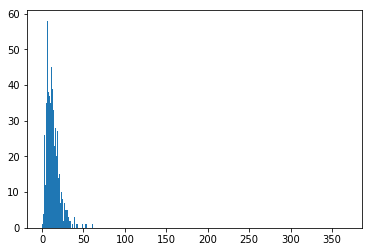

In [66]:
plt.hist(clustered[MEAN_DURATION], bins=1000)
plt.show()

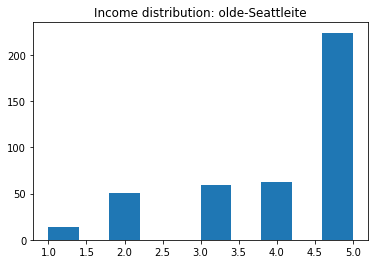

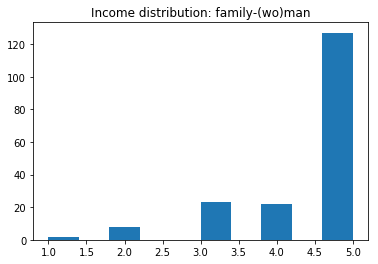

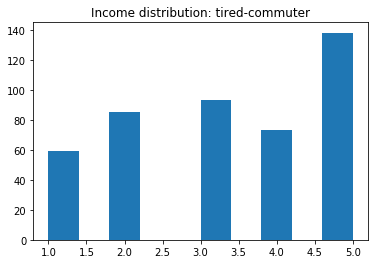

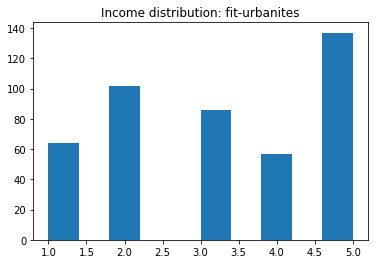

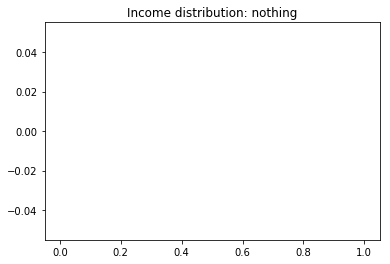

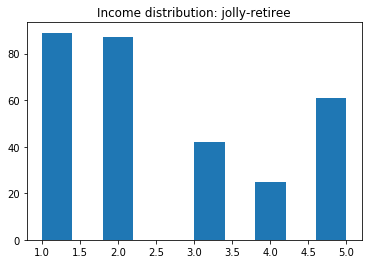



next!!



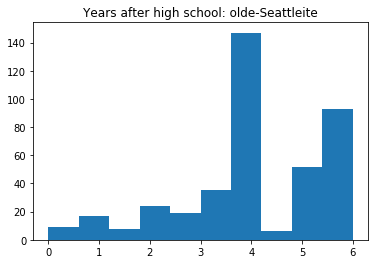

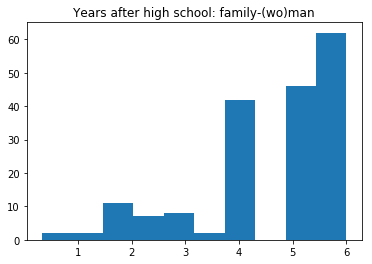

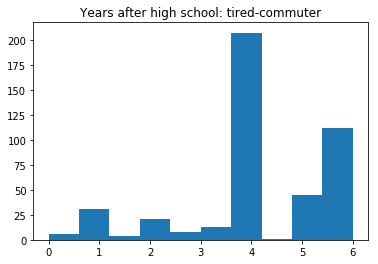

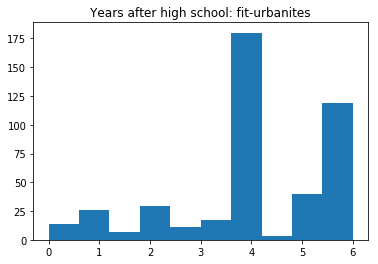

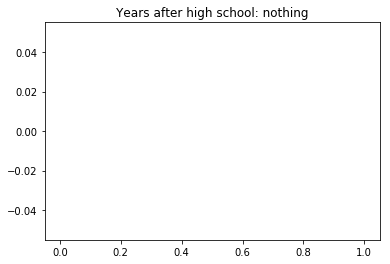

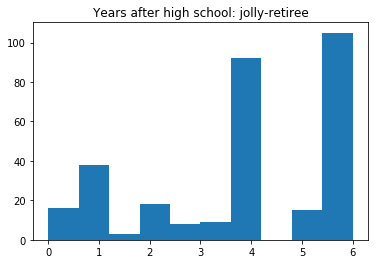

In [57]:
nicknames2 = pd.Series(['olde-Seattleite', 'family-(wo)man', 'tired-commuter', 'fit-urbanites', 'nothing', 'jolly-retiree'])
for i in range(6):
    subdat = clustered[clustered[CLUSTER] == i]
    plt.hist(subdat[INCOME])
    plt.title("Income distribution: " + nicknames2[i])
    plt.show()
    
print("\n")
print("next!!\n")
for i in range(6):
    subdat = clustered[clustered[CLUSTER] == i]
    plt.hist(subdat[YEAR_EDUCATION])
    plt.title("Years after high school: " + nicknames2[i])
    plt.show(

In [251]:
##PCA or t-SNE

# PCA
pca = PCA(n_components=5)
#pca.fit(normalized_res) 
#print(pca.components_)
pca.fit_transform(normalized_res.values)
print(pca.explained_variance_ratio_)

pd.set_option('display.max_columns', 30)
pd.DataFrame(pca.components_, columns=normalized_res.columns, index = ['PC-1','PC-2','PC-3','PC-4','PC-5'])

[ 0.13140364  0.10633742  0.08780147  0.07416905  0.06168527]


,numchildren,hh_wt_revised,hhincome_broad,hhsize,vehicle_count,home_ownership,offpark,year_residence,mean_age,mean_education_year,proportion_employed,proportion_student,mean_distance,mean_depart_time,mean_num_travelers,prop_driving_alone,prop_driving_with_others,prop_transit,prop_biking,prop_walking,mean_duration,prop_went_home,prop_went_work,prop_errands,prop_social,prop_gave_ride,number_of_trips
PC-1,0.363080,0.082576,0.292838,0.391527,0.356098,0.277147,-0.100457,0.114169,-0.107224,0.094598,0.076198,-0.080742,0.032537,-0.053609,0.209197,0.315177,-0.018966,-0.210234,0.001732,-0.192115,0.030784,-0.045982,0.005999,-0.073234,-0.016803,0.299257,0.189717
PC-2,-0.095813,0.044475,-0.062680,-0.104658,0.101380,0.240152,-0.017942,0.367691,0.479307,-0.050900,-0.362572,-0.158873,-0.044894,-0.106077,-0.134776,0.184106,-0.039404,-0.135076,-0.090208,-0.055925,-0.051313,-0.006020,-0.340783,0.387953,-0.057805,-0.024609,-0.108706
PC-3,-0.052678,0.010879,0.073139,0.009490,0.119734,0.059021,-0.014950,0.087266,0.078026,-0.043263,0.079030,-0.049286,0.228199,-0.392412,-0.238996,0.070473,-0.178306,0.190504,0.024090,-0.217003,0.223542,0.258239,0.368298,-0.180133,-0.377815,-0.098410,-0.358181
PC-4,-0.177806,0.006140,0.008309,-0.180315,0.000232,0.023319,-0.006558,-0.002439,0.046590,0.013987,0.044515,-0.021329,0.601286,0.185526,0.025739,0.132668,0.098999,-0.088760,-0.040555,-0.096959,0.605844,-0.171412,-0.063768,-0.010258,0.250537,-0.060454,0.142804
PC-5,0.340333,0.075524,-0.172081,0.280400,-0.218838,-0.043903,0.045529,0.018824,-0.018305,-0.123736,-0.338905,0.145487,0.247479,-0.165068,0.258705,-0.309556,0.109761,0.249016,-0.017742,0.128122,0.243275,0.185488,-0.204089,0.114917,-0.143231,0.233516,-0.028198


0.007030615624898501
0.020527201949189885
0.07450080492425111
0.004636751612795984
nan
0.028148434886000058


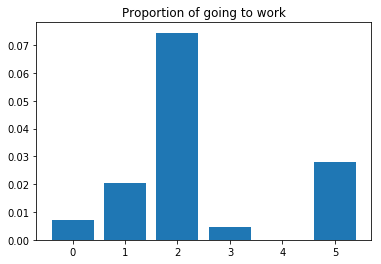

In [33]:
val = {}
for i in range(6):
    subdat = clustered[clustered[CLUSTER] == i]
    print(subdat[PROP_DRIVING_WITH_OTHERS].mean())
    val[i] = subdat[PROP_DRIVING_WITH_OTHERS].mean()
    
plt.bar(list(val.keys()), list(val.values()))
plt.title("Proportion of going to work")
plt.show()

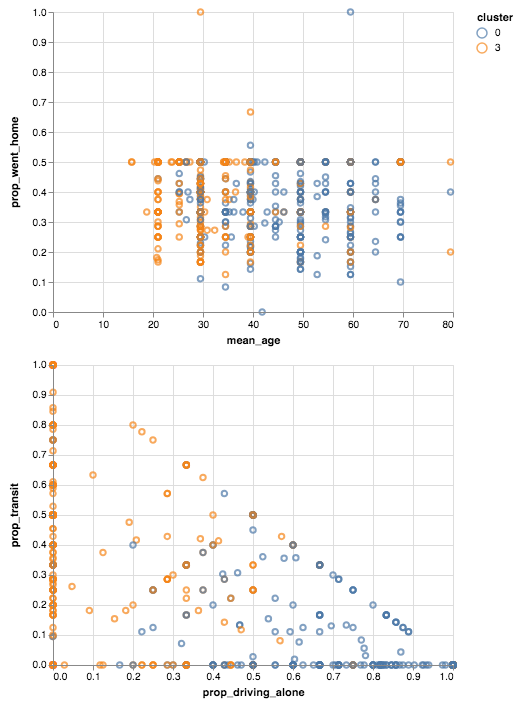

In [32]:
incbik = alt.Chart(clustered[(clustered[CLUSTER] == 0) | (clustered[CLUSTER] == 3)]).mark_point().encode(
    x=MEAN_AGE,
    y=PROP_WENT_HOME,
    color='cluster:N'
)

agebik = alt.Chart(clustered[(clustered[CLUSTER] == 0) | (clustered[CLUSTER] == 3)]).mark_point().encode(
    x=PROP_DRIVING_ALONE,
    y=PROP_TRANSIT,
    color='cluster:N'
)

incbik & agebik


In [256]:
for i in [2, 3, 4, 5, 6]:
    kmeans_labels = KMeans(n_clusters=i, random_state=0).fit_predict(normalized_res)
    print(silhouette_score(normalized_res, kmeans_labels))

0.0926709826817
0.11491359525
0.121579072895
0.0990556888049
0.0905228071769


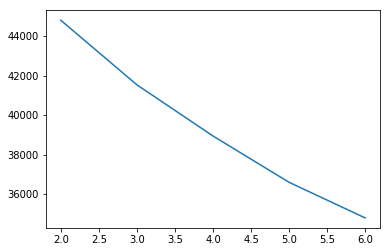

In [257]:
sse = {}
for key in [2, 3, 4, 5, 6]:
    kmeans_test = KMeans(n_clusters=key, random_state=0).fit(normalized_res)
    sse[key] = kmeans_test.inertia_ # Inertia: Sum of distances of samples to their closest cluster cente
plt.plot(list(sse.keys()), list(sse.values()))
plt.show()

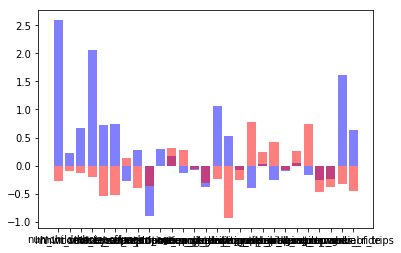

In [258]:
aa = normalized_res[(final_dat[CLUSTER] == 0)].mean()
bb = normalized_res[(final_dat[CLUSTER] == 1)].mean()
plt.bar(list(aa.keys()), list(aa), fc=(0, 0, 1, 0.5))
plt.bar(list(bb.keys()), list(bb), fc=(1, 0, 0, 0.5))
plt.show()